# Steps to extract, format, and pickle the training data

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from scipy.misc import imresize
import csv
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [5]:
def maybe_extract(filename, num_files, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data = []
  for i in range(1,num_files+1):
        data.append(str(i)+'.png')
  data = [
    os.path.join(root, d) for d in data
    if os.path.isfile(os.path.join(root, d))]
  print(len(data))
  return data
  
train_folders = maybe_extract('train.tar.gz', 33402)
#test_folders = maybe_extract('test.tar.gz')
#extra_folders = maybe_extract('extra.tar.gz')

train already present - Skipping extraction of train.tar.gz.
33402


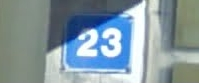

In [22]:
image_file = train_folders[1]
display(Image(image_file))

In [8]:
image_size = 64
pixel_depth = 255.0

def load_data(folder):
  """Load the data for a single letter label."""
  image_files = folder
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  num_images = 0
  for image_file in image_files:
    try:
      image_data = ndimage.imread(image_file, flatten=True, mode='RGB').astype(float) 
      image_data = imresize(image_data, (image_size, image_size)) 
      image_data = (image_data - pixel_depth / 2) / pixel_depth
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1

    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        

In [10]:
train_data =  load_data(train_folders)

Full dataset tensor: (33402, 64, 64)
Mean: 0.0417467
Standard deviation: 0.276468


(64, 64)


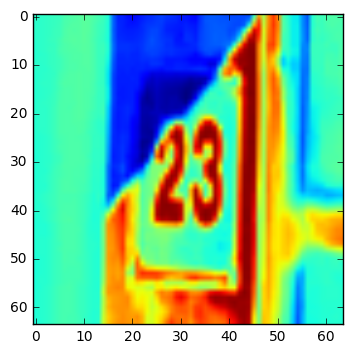

In [23]:
image_data = train_data[1]
plt.figure()
plt.imshow(image_data)
print(image_data.shape)

In [24]:
train_labels = []
num_rows = 73258

with open('digitStruct_train.csv', 'rb') as csvfile:
    x = csv.reader(csvfile, delimiter=',')
    x.next()
    row = x.next()
    label = [int(row[1])]
    
    for _ in range(num_rows - x.line_num):
        next_row = x.next()
        if row[0] == next_row[0]:
            label.append(int(next_row[1]))
        else:
            train_labels.append(label)
            row = next_row
            label = [int(row[1])]
    
    train_labels.append(label)   
    
train_labels = np.array(train_labels)

print(train_labels[1])
print(train_labels.shape)

[2, 3]
(33402,)


In [25]:
pickle_file = 'svhn.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_data,
    'train_labels': train_labels
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

# Train data is pickled

In [3]:
from six.moves import cPickle as pickle
pickle_file = 'svhn.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)

Training set (33402, 64, 64) (33402,)
